In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [92]:
def weights_init(m):
    """Initialize parameters/weights in GAN."""
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    return

class CondGenerator(torch.nn.Module):
    def __init__(self, num_class, latent_dim, embedding_dim, one_hot_encoding):
        super().__init__()
        self.num_class = num_class
        self.latent_dim = latent_dim
        if one_hot_encoding:
            self.embedding_dim = num_class
        else:
            self.embedding_dim = embedding_dim
            self.label_embedding = nn.Embedding(num_class, embedding_dim)
        self.one_hot_encoding = one_hot_encoding

        self.label_channel = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=embedding_dim,
                out_channels=128,
                kernel_size=3,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.noise_channel = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=latent_dim,
                out_channels=128,
                kernel_size=3,
                stride=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.G = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=0
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(
                in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, z, y):
        """The forward function should return batch of images."""
        z = z.reshape(-1, self.latent_dim, 1, 1)
        if self.one_hot_encoding:
            y = F.one_hot(y, num_classes=self.num_class).float()
        else:
            y = self.label_embedding(y)
        y = self.label_channel(y.reshape(-1, self.embedding_dim, 1, 1))
        z = self.noise_channel(z)
        x = torch.cat((z, y), dim=1)
        x = self.G(x)
        return x


class CondDiscriminator(torch.nn.Module):
    def __init__(self, num_class, channel_dim, embedding_dim, one_hot_encoding):
        super().__init__()
        self.num_class = num_class
        self.channel_dim = channel_dim
        if one_hot_encoding:
            self.embedding_dim = num_class
        else:
            self.embedding_dim = embedding_dim
            self.label_embedding = nn.Embedding(num_class, embedding_dim)
        self.one_hot_encoding = one_hot_encoding

        self.label_channel = nn.Sequential(
            nn.Conv2d(
                in_channels=embedding_dim,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.LeakyReLU(0.2),
        )
        self.img_channel = nn.Sequential(
            nn.Conv2d(
                in_channels=channel_dim,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )
        self.D = nn.Sequential(
            # half of the channels comes from the image, and the other half is from the label
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=4,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=2,
                padding=0,
                bias=False,
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(
                in_channels=256,
                out_channels=1,
                kernel_size=3,
                stride=1,
                padding=0,
                bias=False,
            ),
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        """The forward function should return the scores."""
        if self.one_hot_encoding:
            y = F.one_hot(y, num_classes=self.num_class).float()
        else:
            y = self.label_embedding(y)
        y = y[:, :, None, None].repeat(1, 1, 28, 28)
        y = self.label_channel(y)
        x = self.img_channel(x)
        x = torch.concat((x, y), dim=1)
        p = self.D(x)
        return p


class CDCGAN(object):
    def __init__(
        self, num_class, channel_dim, latent_dim, embedding_dim, one_hot_encoding, epochs, lr, device
    ):
        self.G = (
            CondGenerator(num_class, latent_dim, embedding_dim, one_hot_encoding)
            .apply(weights_init)
            .to(device)
        )
        self.D = (
            CondDiscriminator(num_class, channel_dim, embedding_dim, one_hot_encoding)
            .apply(weights_init)
            .to(device)
        )
        self.loss = nn.BCELoss()

        self.d_optimizer = torch.optim.Adam(
            self.D.parameters(), lr=lr, betas=(0.5, 0.999)
        )
        self.g_optimizer = torch.optim.Adam(
            self.G.parameters(), lr=lr, betas=(0.5, 0.999)
        )

        self.num_class = num_class
        self.one_hot_encoding = one_hot_encoding
        self.embedding_dim = embedding_dim
        self.channel_dim = channel_dim
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.lr = lr
        self.device = device

    def train(self, train_loader, verbose_period=2):
        for epoch in range(self.epochs):
            total_d_loss = 0
            total_g_loss = 0
            num_batches = 0
            verbose = (epoch % verbose_period) == 0
            with tqdm(train_loader, unit="batch", disable=not verbose) as bar:
                bar.set_description(f"Epoch {epoch}")
                for images, y in bar:
                    batch_size = images.size(0)
                    # Step 1: Train discriminator
                    z = torch.rand((batch_size, self.latent_dim)).to(self.device)

                    real_labels = torch.ones(batch_size)
                    fake_labels = torch.zeros(batch_size)

                    images, y = images.to(self.device), y.to(self.device).long()

                    real_labels, fake_labels = real_labels.to(
                        self.device
                    ), fake_labels.to(self.device)

                    # Compute the BCE Loss using real images
                    real_scores = self.D(images, y)
                    real_scores = torch.squeeze(real_scores)
                    d_loss_real = self.loss(real_scores, real_labels)

                    # Compute the BCE Loss using fake images
                    fake_images = self.G(z, y)
                    fake_scores = self.D(fake_images, y)
                    fake_scores = torch.squeeze(fake_scores)
                    d_loss_fake = self.loss(fake_scores, fake_labels)

                    # Optimize discriminator
                    d_loss = d_loss_real + d_loss_fake
                    self.D.zero_grad()
                    d_loss.backward()
                    # max log(D(x)) + log(1 - D(G(z))) <=> min -[ log(D(x)) + log(1 - D(G(z))) ]
                    self.d_optimizer.step()

                    # Step 2: Train Generator
                    z = torch.randn(batch_size, self.latent_dim).to(self.device)

                    fake_images = self.G(z, y)
                    fake_scores = self.D(fake_images, y)
                    fake_scores = torch.squeeze(fake_scores)
                    g_loss = self.loss(fake_scores, real_labels)

                    self.D.zero_grad()
                    self.G.zero_grad()
                    g_loss.backward()
                    # min log(1 - D(G(z))) => min -[ log(D(G(z))) ]
                    self.g_optimizer.step()

                    # update bar
                    num_batches += 1
                    total_d_loss += d_loss.item()
                    total_g_loss += g_loss.item()
                    bar.set_postfix(
                        d_loss=float(total_d_loss / num_batches),
                        g_loss=float(total_g_loss / num_batches),
                    )
            if total_d_loss / num_batches < 1e-3 or total_g_loss / num_batches > 8:
                print(
                    f"Discriminator loss is too small and generator loss is too high at epoch:{epoch}, " +
                    "which indicate a potential saturation problem."
                )
                print("Now, re-initialize and re-train...")
                self.__init__(
                    self.num_class,
                    self.channel_dim,
                    self.latent_dim,
                    self.embedding_dim,
                    self.one_hot_encoding,
                    self.epochs,
                    self.lr,
                    self.device,
                )
                self.train(train_loader, verbose_period=verbose_period)
                return
        return

    def generate_img(self, number_of_images, class_label, randomness=0.1):
        samples = (
            self.G(
                (randomness * torch.randn((number_of_images, self.latent_dim))).to(
                    self.device
                ),
                (class_label * torch.ones(number_of_images)).long().to(self.device),
            )
            .detach()
            .cpu()
            .reshape(-1, 1, 28, 28)
        )
        samples = samples * 0.5 + 0.5
        return samples


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)


100%|██████████| 9912422/9912422 [00:00<00:00, 80008527.51it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42031816.04it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32008679.86it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5227916.79it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [80]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [101]:
model = CDCGAN(
    num_class=10,
    channel_dim=1,
    latent_dim=64,
    embedding_dim=16,
    one_hot_encoding=False,
    epochs=20,
    lr=2e-4,
    device=device
)
model.train(train_loader, verbose_period=1)


Epoch 19: 100%|██████████| 235/235 [00:19<00:00, 12.03batch/s, d_loss=0.81, g_loss=1.16]


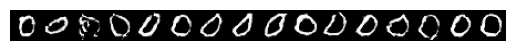

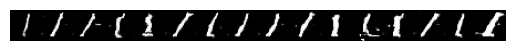

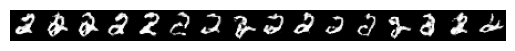

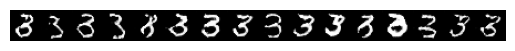

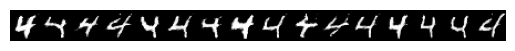

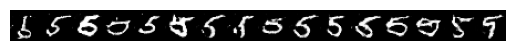

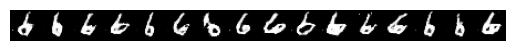

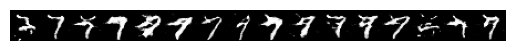

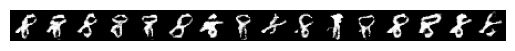

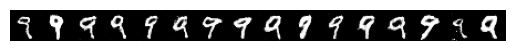

In [105]:
for i in range(10):
    samples = model.generate_img(16, i, randomness=0.01)
    plt.imshow(
        torch.permute(make_grid(samples, nrow=16, padding=0), (1,2,0)),
        cmap="gray"
    )
    plt.axis("off")
    plt.show()


In [1]:
from sklearn.metrics.pairwise import euclidean_distances # noqa : E502


In [72]:
digit_embedding = model.G.label_embedding.weight.data.cpu().numpy()


In [74]:
distance = euclidean_distances(digit_embedding, digit_embedding)
((distance - distance.min()) / (distance.max() - distance.min())).round(2)


array([[0.  , 0.64, 0.79, 0.67, 0.67, 0.58, 0.64, 0.69, 0.57, 0.52],
       [0.64, 0.  , 0.84, 0.63, 0.61, 0.66, 0.76, 0.7 , 0.7 , 0.76],
       [0.79, 0.84, 0.  , 0.87, 0.73, 1.  , 0.77, 0.52, 0.81, 0.58],
       [0.67, 0.63, 0.87, 0.  , 0.65, 0.57, 0.72, 0.73, 0.71, 0.65],
       [0.67, 0.61, 0.73, 0.65, 0.  , 0.6 , 0.68, 0.62, 0.71, 0.61],
       [0.58, 0.66, 1.  , 0.57, 0.6 , 0.  , 0.76, 0.76, 0.66, 0.74],
       [0.64, 0.76, 0.77, 0.72, 0.68, 0.76, 0.  , 0.72, 0.47, 0.68],
       [0.69, 0.7 , 0.52, 0.73, 0.62, 0.76, 0.72, 0.  , 0.62, 0.57],
       [0.57, 0.7 , 0.81, 0.71, 0.71, 0.66, 0.47, 0.62, 0.  , 0.6 ],
       [0.52, 0.76, 0.58, 0.65, 0.61, 0.74, 0.68, 0.57, 0.6 , 0.  ]],
      dtype=float32)

In [61]:
digit_embedding = model.D.label_embedding.weight.data.cpu().numpy()


In [62]:
euclidean_distances(digit_embedding, digit_embedding).round(2)


array([[0.  , 3.24, 2.63, 2.74, 3.08, 3.84, 3.07, 1.8 , 2.93, 4.4 ],
       [3.24, 0.  , 0.93, 1.61, 0.82, 2.33, 1.77, 1.65, 2.63, 1.99],
       [2.63, 0.93, 0.  , 1.09, 0.65, 2.69, 2.02, 0.91, 2.54, 2.62],
       [2.74, 1.61, 1.09, 0.  , 0.9 , 3.71, 2.86, 1.07, 3.47, 3.46],
       [3.08, 0.82, 0.65, 0.9 , 0.  , 3.02, 2.25, 1.31, 3.09, 2.61],
       [3.84, 2.33, 2.69, 3.71, 3.02, 0.  , 1.52, 3.12, 1.62, 1.65],
       [3.07, 1.77, 2.02, 2.86, 2.25, 1.52, 0.  , 2.32, 2.3 , 1.42],
       [1.8 , 1.65, 0.91, 1.07, 1.31, 3.12, 2.32, 0.  , 2.62, 3.27],
       [2.93, 2.63, 2.54, 3.47, 3.09, 1.62, 2.3 , 2.62, 0.  , 3.03],
       [4.4 , 1.99, 2.62, 3.46, 2.61, 1.65, 1.42, 3.27, 3.03, 0.  ]],
      dtype=float32)